**Predicting which customers will purchase a quoted insurance plan**

**1. Reading data from the given CSV files that is stored in Google Drive.**

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


---



**2. Load train data from csv file.**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime

dataPath = '/gdrive/MyDrive/PGD Assignment Notebooks/train.csv'
df = pd.read_csv(dataPath)
print("Total no. of records in train dataset is: {0}".format(df['QuoteNumber'].count()))
#df.rename(columns={'GeographicField64' : 'State', 'Field7' : 'BMI', 'Field12' : 'Is_Smoker', 'PropertyField37': 'IS_Urban', 'Field10' : 'Premium_Amount', 'PersonalField11': 'Family_Size', 'PropertyField14' :'Property_Type'}, inplace = True)

df

Total no. of records in train dataset is: 260753


QuoteNumber Original_Quote_Date  ...  GeographicField63 GeographicField64
0                 1          2013-08-16  ...                  N                CA
1                 2          2014-04-22  ...                  N                NJ
2                 4          2014-08-25  ...                  N                NJ
3                 6          2013-04-15  ...                  N                TX
4                 8          2014-01-25  ...                  N                IL
...             ...                 ...  ...                ...               ...
260748       434584          2013-05-16  ...                  N                TX
260749       434585          2014-12-07  ...                  N                TX
260750       434586          2014-02-18  ...                  N                NJ
260751       434587          2014-04-08  ...                  N                NJ
260752       434588          2013-03-19  ...                  N                NJ

[260753 rows x 299 columns]

***Observation:*** Based on the existing feature names, renamed some of the features for better understanding of the feature.

---



**3. Let's split the "Original_Quote_Date" feature into Year, Month and Is_Weekend to add more features to the existing train dataset.**

---



In [3]:
str_date = df['Original_Quote_Date']
year_lst=[]
month_lst=[]
weekend_lst=[]
date_lst=[]

for i in str_date:
  year_lst.append(int(i[0:4]))
  month_lst.append(int(i[5:7]))
  date_lst.append(int(i[8:]))
  d = datetime(int(i[0:4]), int(i[5:7]), int(i[8:]))
  if d.weekday() > 4:
    weekend_lst.append(1)
  else:
    weekend_lst.append(0)

df['Year'] = year_lst
df['Month'] = month_lst
df['Is_Weekend'] = weekend_lst

df.drop(['Original_Quote_Date'], axis = 1, inplace = True)

df

QuoteNumber  QuoteConversion_Flag Field6  ...  Year  Month  Is_Weekend
0                 1                     0      B  ...  2013      8           0
1                 2                     0      F  ...  2014      4           0
2                 4                     0      F  ...  2014      8           0
3                 6                     0      J  ...  2013      4           0
4                 8                     0      E  ...  2014      1           1
...             ...                   ...    ...  ...   ...    ...         ...
260748       434584                     0      J  ...  2013      5           0
260749       434585                     0      J  ...  2014     12           1
260750       434586                     0      F  ...  2014      2           0
260751       434587                     0      F  ...  2014      4           0
260752       434588                     0      F  ...  2013      3           0

[260753 rows x 301 columns]

***Observation:*** Split the Original_Quote_Date into Month, Year and IS_Weekend and add it as extra features to the original train dataset. Hence we are adding more features to the existing train dataset.

---



**4. Using LabelEncoder, convert String to Numeric Feature for the features having unique count greater than 5.**

---


In [4]:
#Using LabelEncoder, convert String to Numeric Feature for the features having unique count greater than 5.

cols = df.columns
num_cols = df._get_numeric_data().columns

categorical_features = sorted(list(set(cols) - set(num_cols)))
df_cat_features_lt_str = df[categorical_features].nunique().to_frame().to_string()

#Give names to the output data
df_cat_features_lt = pd.read_csv(StringIO(df_cat_features_lt_str), sep='\s+', names = ['Field', 'Unique_Count'])
df_cat_features_lt = df_cat_features_lt[df_cat_features_lt.Field != '0']

from sklearn.preprocessing import LabelEncoder

for i in df_cat_features_lt[df_cat_features_lt['Unique_Count'] >5]['Field']:
  df[i] = enc = LabelEncoder().fit_transform(df[i])

df

QuoteNumber  QuoteConversion_Flag  Field6  ...  Year  Month  Is_Weekend
0                 1                     0       1  ...  2013      8           0
1                 2                     0       5  ...  2014      4           0
2                 4                     0       5  ...  2014      8           0
3                 6                     0       6  ...  2013      4           0
4                 8                     0       4  ...  2014      1           1
...             ...                   ...     ...  ...   ...    ...         ...
260748       434584                     0       6  ...  2013      5           0
260749       434585                     0       6  ...  2014     12           1
260750       434586                     0       5  ...  2014      2           0
260751       434587                     0       5  ...  2014      4           0
260752       434588                     0       5  ...  2013      3           0

[260753 rows x 301 columns]

***Observation:*** Convert String to Numeric Feature using LabelEncoder for the features having unique count of greater than 5.

---



**5. Using One-Hot Encoding to convert String to Numeric Features for the features having unique count greater than 2 and less than 5.**

---

In [5]:
#Using One-Hot Encoding to convert String to Numeric Features for the features having unique count greater than 2 and less than 5.

from sklearn.preprocessing import OneHotEncoder

#for i in df_cat_features_lt.loc[(df_cat_features_lt['Unique_Count'] < 10) & (df_cat_features_lt['Unique_Count'] > 2)]['Field']:
for i in df_cat_features_lt.loc[(df_cat_features_lt['Unique_Count'] > 2) & (df_cat_features_lt['Unique_Count'] <= 5)]['Field']:
  enc = OneHotEncoder(handle_unknown = 'ignore')
  enc_df_state = pd.DataFrame(enc.fit_transform(df[[i]]).toarray())
  enc_df_state.columns = enc.get_feature_names([i])
  df = df.join(enc_df_state)
  df.drop([i], axis = 1, inplace = True)

# Converting categorical features having only 2 values into numerical 1's and 0's.
for j in df_cat_features_lt.loc[(df_cat_features_lt['Unique_Count'] == 2)]['Field']:
  df[j].replace({'Y' : 1, 'N' : 0}, inplace = True)

df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

QuoteNumber  QuoteConversion_Flag  ...  PropertyField33_G  PropertyField33_H
0                 1                     0  ...                1.0                0.0
1                 2                     0  ...                0.0                1.0
2                 4                     0  ...                0.0                1.0
3                 6                     0  ...                1.0                0.0
4                 8                     0  ...                0.0                1.0
...             ...                   ...  ...                ...                ...
260748       434584                     0  ...                1.0                0.0
260749       434585                     0  ...                0.0                0.0
260750       434586                     0  ...                1.0                0.0
260751       434587                     0  ...                0.0                0.0
260752       434588                     0  ...                1.0                0.0

[260753 rows x 318 columns]

***Observation:*** Convert all the Categorical features to Numeric features using One-Hot Encoding having unique count features greater than 2 and less than equal to 5.
Also, converting features containing Y's to 1's and N's to 0's for Numeric purpose.

---



**6. Calculate the Categorical features. It should be blank as we have converted all Categorical features to Numeric.**

---

In [6]:
# Calculate the Categorical features.
# It should be blank as we have converted all Categorical features to Numeric.

cols = df.columns
num_cols = df._get_numeric_data().columns

categorical_features = sorted(list(set(cols) - set(num_cols)))
df_cat_features_str = df[categorical_features].nunique().to_frame().to_string()

#Give names to the output data
print("Categorical Features and their Count!\n-------------------------------------")
df_cat_features = pd.read_csv(StringIO(df_cat_features_str), sep='\s+', names = ['Field', 'Unique_Count'])
df_cat_features = df_cat_features[df_cat_features.Field != '0']
df_cat_features

# CoverageField9 -> 1 to 12 numbers

Categorical Features and their Count!
-------------------------------------


Field Unique_Count
0     Empty    DataFrame
1  Columns:          [0]
2    Index:           []

***Observation:*** Now all the Categorical features are being converted to Numeric features.

---



**7. Removing high Correlated features from the train dataset.**

---

In [7]:
# Removing high correlated features from the train dataset.
from numpy import cov

field_cols = []
for i in df.columns:
  if i.startswith('Field'):
    field_cols.append(i)

coverage_field_cols = []
for i in df.columns:
  if i.startswith('CoverageField'):
    coverage_field_cols.append(i)

sales_field_cols = []
for i in df.columns:
  if i.startswith('SalesField'):
    sales_field_cols.append(i)

personal_field_cols = []
for i in df.columns:
  if i.startswith('PersonalField'):
    personal_field_cols.append(i)

property_field_cols = []
for i in df.columns:
  if i.startswith('PropertyField'):
    property_field_cols.append(i)

graphic_field_cols = []
for i in df.columns:
  if i.startswith('GeographicField'):
    graphic_field_cols.append(i)

all_features_list = ['field_cols', 'coverage_field_cols', 'sales_field_cols', 'personal_field_cols', 'property_field_cols', 'graphic_field_cols']

total_high_corr_features=[]

corr_matrix = df[field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for Field is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[coverage_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for CoverageField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[sales_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for SalesField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[personal_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for PersonalField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[property_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for PropertyField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[graphic_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for GeographicField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

print("Total High Corr Features:\n{0}".format(total_high_corr_features))

df.drop(columns=total_high_corr_features, inplace = True)

High Corr Feature that can be removed for Field is:[]
High Corr Feature that can be removed for CoverageField is:['CoverageField1B', 'CoverageField2A', 'CoverageField2B', 'CoverageField3A', 'CoverageField3B', 'CoverageField4A', 'CoverageField4B', 'CoverageField11B']
High Corr Feature that can be removed for SalesField is:['SalesField12', 'SalesField15']
High Corr Feature that can be removed for PersonalField is:['PersonalField2', 'PersonalField4B', 'PersonalField10B', 'PersonalField23', 'PersonalField24', 'PersonalField25', 'PersonalField26', 'PersonalField32', 'PersonalField33', 'PersonalField35', 'PersonalField36', 'PersonalField37', 'PersonalField38', 'PersonalField41', 'PersonalField42', 'PersonalField43', 'PersonalField44', 'PersonalField45', 'PersonalField46', 'PersonalField47', 'PersonalField48', 'PersonalField50', 'PersonalField51', 'PersonalField52', 'PersonalField53', 'PersonalField55', 'PersonalField56', 'PersonalField57', 'PersonalField58', 'PersonalField60', 'PersonalField

***Observation:*** Group the features according to the main Features called Field, CoverageField, SalesField, PersonalField, PropertyField and GeographicField.

>


***Conclusion:*** We are removing the highly correlated features to avoid the multicollinearity, i.e., if two features are highly correlated, then they will have nearly exact information. Including both the features may impact/weaken the model.

---


**8. Drop the features which are not necessary or doesn't give importance to the model, i.e., get the fields in the original DataFrame where any field which has only one value in the whole dataset and drop those fields as it is not needed or not useful or stand-alone feature in prediction.**

---



In [8]:
#Get the unique values for each Field in the DataFrame and converting to String to give header to the output for easy of querying the dataset in DataFrame.
df_str = df.nunique().to_frame().to_string()

#Give names to the output data
df_new = pd.read_csv(StringIO(df_str), sep='\s+', names = ['Field', 'Unique_Count'])

#Will ignore the unwanted field with field value '0' from the new DataFrame
df_drop_features = df_new.loc[1:]

#List the unique fields having a single value in the entire train dataset
df_drop_features['Unique_Count'].astype(int)

#Finally drop the fields from the train dataset
fieldsToDrop = df_drop_features[df_drop_features['Unique_Count'] == 1]['Field'].values;
print("Features that are being dropped from the train dataset are: \n{0}".format(fieldsToDrop))

df.drop(columns=fieldsToDrop, axis = 1, inplace = True)

df.drop(columns=['QuoteNumber'], inplace=True)

Features that are being dropped from the train dataset are: 
['PropertyField6' 'GeographicField10A']


***Observation:*** Dropping the stand-alone features which doesn't add any value in prediction and also dropping the unique QuoteNumber as well.

---


**9. Replacing all -1's to NaN.**

---


In [9]:
# Replacing all -1 values to NaN values from the train dataset.

for col in df:
  df[col].replace({-1 : np.nan}, inplace = True)

***Observation:*** Once replaced -1's to NaN, we will then convert all NaN to a numeric values using some Imputers.

---


**10. Get the featurs which has empty/NaN values and their count and their percentage.**

---


In [10]:
#Get the features which has empty/NaN values and their count and their percentage.
total_count = df.shape[0]

print("Features having Empty/NULL/NaN value count!\n-------------------------------------------")
dfsr = df.isnull().sum()
df_nan = dfsr[dfsr.values != 0].to_frame().to_string()

#Give names to the output data
df_nan_new = pd.read_csv(StringIO(df_nan), sep='\s+', names = ['Field', 'Nan_Count', 'Nan_Percent'])

df_nan_new = df_nan_new[df_nan_new.Field != '0']
df_nan_new

# Get the NaN percentage from the total count.
df_null = df[df.columns[df.eq(-1).any()]]
total_null_cols = df_null.columns
nan_new_count = df_nan_new['Field'].count()

for i in total_null_cols:
  nan_new_count += 1
  df_nan_new.loc[nan_new_count] = [i] + [int(df.QuoteNumber[df[i] == -1].count())] + [0]

for ind, j in df_nan_new.iterrows():
  df_nan_new['Nan_Percent'] = round((df_nan_new['Nan_Count'] / total_count)*100,2)

df_nan_new

Features having Empty/NULL/NaN value count!
-------------------------------------------


Field  Nan_Count  Nan_Percent
1      CoverageField1A      362.0         0.14
2     CoverageField11A      765.0         0.29
3         SalesField2A      362.0         0.14
4         SalesField2B      362.0         0.14
5      PersonalField4A    24526.0         9.41
..                 ...        ...          ...
81  GeographicField60B       12.0         0.00
82  GeographicField61A   254170.0        97.48
83  GeographicField61B       12.0         0.00
84  GeographicField62A   254144.0        97.47
85  GeographicField62B       22.0         0.01

[85 rows x 3 columns]

***Observation:*** There are 85 features having atleast one NaN value.

---


**11. Dropping the features that has more than 75% of NULL/NaN values.**

---


In [11]:
#Dropping the features that has more than 75% of NULL/NaN values.

for k in df_nan_new[df_nan_new['Nan_Percent'] > 75].Field:
  df.drop(columns=k, axis = 1, inplace = True)

df


QuoteConversion_Flag  Field6  ...  PropertyField33_G  PropertyField33_H
0                          0       1  ...                1.0                0.0
1                          0       5  ...                0.0                1.0
2                          0       5  ...                0.0                1.0
3                          0       6  ...                1.0                0.0
4                          0       4  ...                0.0                1.0
...                      ...     ...  ...                ...                ...
260748                     0       6  ...                1.0                0.0
260749                     0       6  ...                0.0                0.0
260750                     0       5  ...                1.0                0.0
260751                     0       5  ...                0.0                0.0
260752                     0       5  ...                1.0                0.0

[260753 rows x 178 columns]

***Observation:*** Since there more NULL/NaN values and by removing those features from the train dataset, we can get more retain more accurate data.

---


**12. Get the features having NULL/NaN values of less than 75%.**

---


In [12]:
# Get the features having NULL/NaN values of less than 75%
#df_nan_new[df_nan_new['Nan_Percent'] < 75]

df_nan_new_cnt = df_nan_new[df_nan_new['Nan_Percent'] < 75]

#df_nan_new_cnt
cnt = 0

for i in df_nan_new_cnt.Field:
  #print("Feature is {0} and Unique Count is {1}".format(i, df[i].nunique()))
  df_nan_new_cnt.loc[df_nan_new_cnt.Field == i, 'Unique_Count'] = df[i].nunique()

df_nan_new_cnt

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Field  Nan_Count  Nan_Percent  Unique_Count
1      CoverageField1A      362.0         0.14          25.0
2     CoverageField11A      765.0         0.29          25.0
3         SalesField2A      362.0         0.14          25.0
4         SalesField2B      362.0         0.14          25.0
5      PersonalField4A    24526.0         9.41          25.0
..                 ...        ...          ...           ...
78  GeographicField58A       11.0         0.00          25.0
79  GeographicField59A        2.0         0.00          25.0
81  GeographicField60B       12.0         0.00          25.0
83  GeographicField61B       12.0         0.00          24.0
85  GeographicField62B       22.0         0.01          18.0

[72 rows x 4 columns]

***Observation:*** There are 72 features having less than 25% of NULL/NaN.

---

**13. Using SimpleImputer, convert all NULL/NaN valuse to a Numeric value using MEAN strategy.**

---

In [13]:
# Using SimpleImputer to convert all NULL/NaN values to a numeric value using "MEAN" strategy.

dfsr = df.isnull().sum()
df_nan = dfsr[dfsr.values != 0].to_frame().to_string()
df_nan

#Give names to the output data
df_nan_new = pd.read_csv(StringIO(df_nan), sep='\s+', names = ['Field', 'Nan_Count', 'Nan_Percent'])

df_nan_new = df_nan_new[df_nan_new.Field != '0']
df_nan_new

final_df = df.copy()

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

imputer = imputer.fit(df[df_nan_new.Field])

final_df[df_nan_new.Field] = imputer.transform(df[df_nan_new.Field])

final_df

QuoteConversion_Flag  Field6  ...  PropertyField33_G  PropertyField33_H
0                          0       1  ...                1.0                0.0
1                          0       5  ...                0.0                1.0
2                          0       5  ...                0.0                1.0
3                          0       6  ...                1.0                0.0
4                          0       4  ...                0.0                1.0
...                      ...     ...  ...                ...                ...
260748                     0       6  ...                1.0                0.0
260749                     0       6  ...                0.0                0.0
260750                     0       5  ...                1.0                0.0
260751                     0       5  ...                0.0                0.0
260752                     0       5  ...                1.0                0.0

[260753 rows x 178 columns]

***Observation:*** Finally brought down the number of features to 178 including QuoteConverstion_Flag.

---

**14. Re-checking if there are any missing values in any feature.**

---

In [14]:
#Again calculate the Features and their NaN percentage.
# It should be blank as we have converted all NULL/NaN features to Numeric.

total_count = final_df.shape[0]

print("Features having Empty/NULL/NaN value count!\n-------------------------------------------")
dfsr = final_df.isnull().sum()
df_nan = dfsr[dfsr.values != 0].to_frame().to_string()
#df_nan

#Give names to the output data
df_nan_new = pd.read_csv(StringIO(df_nan), sep='\s+', names = ['Field', 'Nan_Count', 'Nan_Percent'])

df_nan_new = df_nan_new[df_nan_new.Field != '0']

# Get the NaN percentage from the total count.
df_null = final_df[final_df.columns[final_df.eq(-1).any()]]

total_null_cols = df_null.columns

nan_new_count = df_nan_new['Field'].count()

total_null_cols

Features having Empty/NULL/NaN value count!
-------------------------------------------


Index([], dtype='object')

***Observation:*** There are no Empty/NULL/NaN values in any of the feature.

---

**15. Get the topmost 20 features using ExtraTreesClassifier.**

---

PropertyField37     0.110259
PersonalField9      0.054963
PersonalField12     0.054597
SalesField5         0.051196
PersonalField10A    0.024612
PersonalField1      0.022240
SalesField4         0.022057
SalesField1B        0.019244
PropertyField34     0.015324
CoverageField8      0.013420
SalesField1A        0.011622
PropertyField35     0.010786
PersonalField13     0.010388
CoverageField9      0.010004
Field7              0.009990
CoverageField6A     0.009220
SalesField2B        0.009033
CoverageField6B     0.009026
SalesField3         0.007865
PersonalField4A     0.007860
dtype: float64


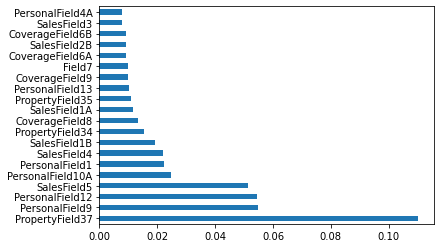

In [15]:
# Feature importance using ExtraTreesClassifier

y = final_df['QuoteConversion_Flag']
X = final_df.drop("QuoteConversion_Flag", axis = 1)

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X, y)
#print(model.feature_importances_)

feat_importance = pd.Series(model.feature_importances_, index = X.columns)
feat_importance.nlargest(20).plot(kind='barh')
print(feat_importance.nlargest(20))
plt.show()

***Observation:*** Feature "PropertyField37" has the topmost feature and followed by other features. Here we are fetching 20 topmost features.

---

**16. Plotting the Correlation Matrix.**

---

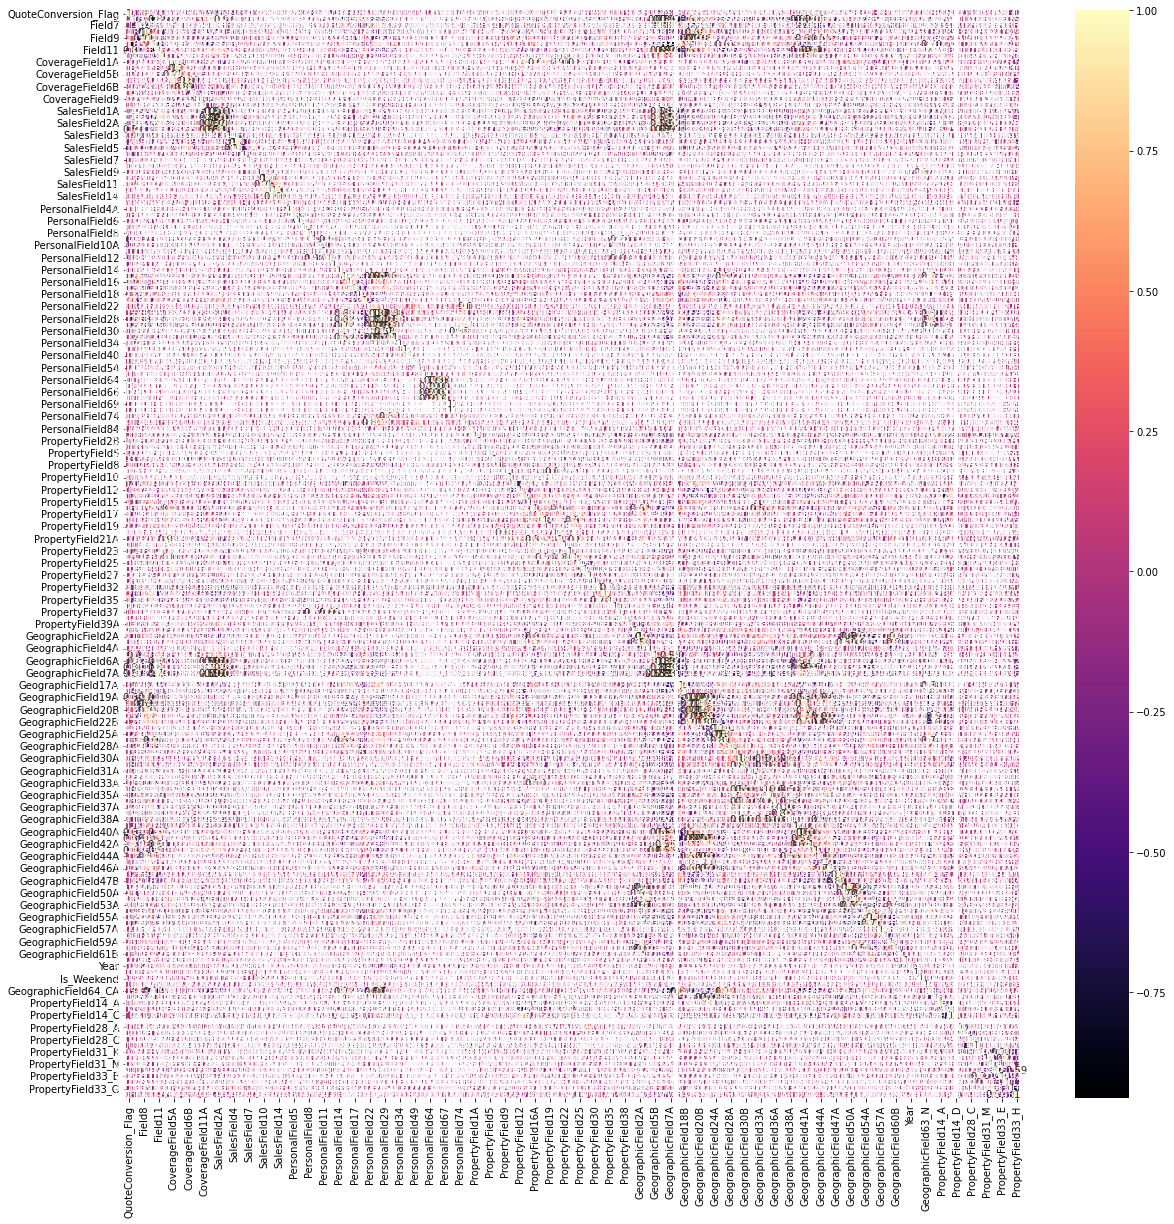

In [16]:
# Correlation matrix with HeatMap.

y = final_df['QuoteConversion_Flag'].head(20000)
X = final_df.head(20000)

corr_mat = X.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(20,20))

h = sns.heatmap(X[top_corr_features].corr(), annot = True, cmap = "magma")

**17. Visualization using PCA by taking top 20K datapoints.**

---




In [17]:
#Visualization using PCA

# Seperating X-data and Y-data

quote_flag = final_df['QuoteConversion_Flag']
X = final_df.drop("QuoteConversion_Flag", axis = 1)

print(quote_flag.shape)
print(X.shape)

(260753,)
(260753, 177)


***Observation:*** By dropping the QuoteConversion_Flag, we now have 177 features.

---

In [18]:
#Let's take first 20K data-points.

flags = quote_flag.head(20000)
data_pts = X.head(20000)

print(data_pts.shape)

(20000, 177)


***Conclusion:*** We are taking first 20K for simplicity.

---

In [19]:
# Data Pre-processing using Data Standardization.

from sklearn.preprocessing import StandardScaler
std_data = StandardScaler().fit_transform(data_pts)
print(std_data.shape)

(20000, 177)


***Observation:*** We are standardising the using StandardScaler.

---

In [20]:
# Let's check whether the normalized data has a mean of zero and a standard deviation of one.

np.mean(std_data), np.std(std_data)

(1.165410517618727e-16, 0.994334232022488)

***Observation:*** Mean - 1.16 and Std. Dev - 0.99.

---

In [21]:
# Initialize PCA
from sklearn import decomposition
from sklearn.decomposition import PCA
import seaborn as sn
pca = decomposition.PCA()

# PCA configuration
pca_comp = PCA(n_components = 2)
pca_data = pca_comp.fit_transform(std_data)

pca_DF = pd.DataFrame(data = pca_data, columns = ['PC1', 'PC2'])
pca_DF.head()

PC1       PC2
0  5.828535  0.320534
1 -4.327388 -4.820052
2 -3.622082 -2.744324
3 -3.105972  5.617245
4 -2.560097 -1.195468

In [22]:
print('Variation per PC:{}'.format(pca_comp.explained_variance_ratio_))

Variation per PC:[0.09920993 0.06874362]


In [23]:
# Plotting PCA
import plotly.express as px

pca_data = np.vstack((pca_data.T, flags)).T

print("Total Explained Variance:{0}".format(pca_comp.explained_variance_ratio_.sum()*100))

pca_plt = px.scatter(pca_data, x=0, y=1, color=flags)

pca_plt.show()

Total Explained Variance:16.795355405276254




---



**18. Rename the features for easy to understand.**

---



In [24]:
final_df
#df.rename(columns={'GeographicField64' : 'State', 'Field7' : 'BMI', 'Field12' : 'Is_Smoker', 'PropertyField37': 'IS_Urban', 'Field10' : 'Premium_Amount', 'PersonalField11': 'Family_Size', 'PropertyField14' :'Property_Type'}, inplace = True)
final_df.rename(columns={'Field7' : 'BMI'}, inplace = True)



***Observation:*** Renaming the feature Field7 to BMI for better understanding.

---



**19. Bar Plot to check the percentage of data between Customers taken Quote and Customers not taken Quote.**

Quote Not taken: 81.25%
Quote taken: 18.75%


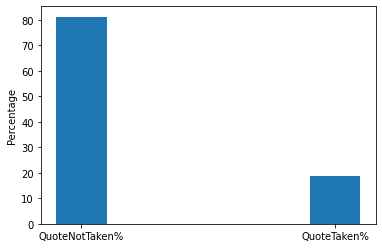

In [25]:
quoteNotTakenCount = final_df[final_df['QuoteConversion_Flag']==0].shape[0]
quoteTakenCount = final_df[final_df['QuoteConversion_Flag']==1].shape[0]
totalCount = final_df.shape[0]

quoteNotTakenPercent = round((quoteNotTakenCount/totalCount)*100,2)
quoteTakenPercent = round((quoteTakenCount/totalCount)*100,2)

print("Quote Not taken: {0}%\nQuote taken: {1}%".format(quoteNotTakenPercent, quoteTakenPercent))

x_axis = ("QuoteNotTaken%", "QuoteTaken%")
x_pos = np.arange(len(x_axis))

height = [quoteNotTakenPercent, quoteTakenPercent]
plt.bar(x_pos, height, width = 0.2)
plt.xticks(x_pos, x_axis)
plt.ylabel('Percentage')
plt.show()

***Observation:*** There are 18.75% of Customers have taken the Quote and remaining 81.25% of Customers have not taken the Quote.

---

**20. Count Plot between State and Quote_Conversion_Flag.**

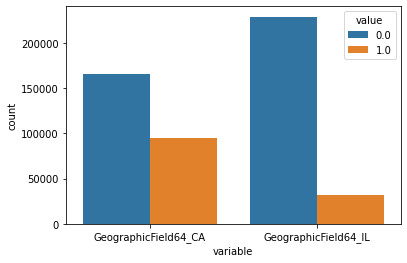

In [26]:
df_cp = final_df[['GeographicField64_CA','GeographicField64_IL']]
sns.countplot(x='variable', hue = 'value', data = pd.melt(df_cp))
plt.show()

***Observation:*** Customers in CA have taken more Quote when compared to Customers in IL.

---



**21. Plot for new Features Month, Year and Is_Weekend.**

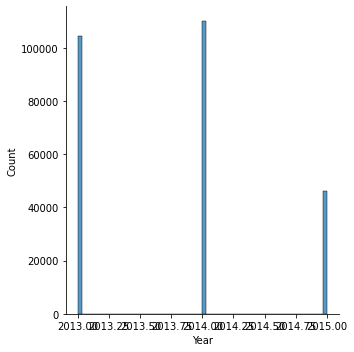

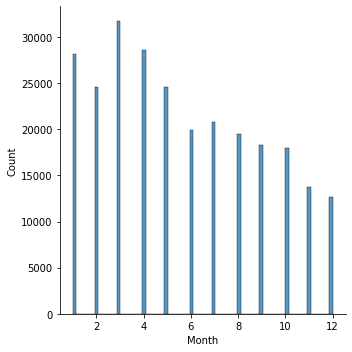

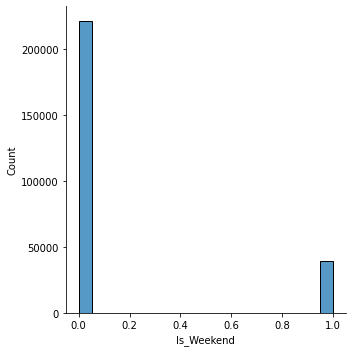

In [27]:
#plt.subplot(1,3,1)
sns.displot(final_df['Year'])

#plt.subplot(1,3,2)
sns.displot(final_df['Month'])

#plt.subplot(1,3,3)
sns.displot(final_df['Is_Weekend'])

plt.show()

***Observation:*** There are more records in the year 2014.
Also, there are more records in the month of March.
Customers usually prefer Weekdays to buy a Quote or not when compared to Weekends.

---

**22. BMI vs QuoteConversion_Flag**

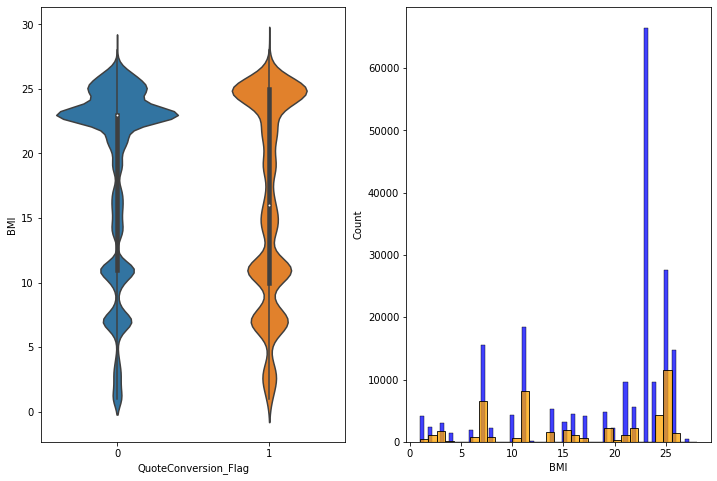

In [28]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'QuoteConversion_Flag', y = 'BMI', data = final_df[0:])

plt.subplot(1,2,2)
sns.histplot(final_df[final_df['QuoteConversion_Flag'] == 0]['BMI'][0:] , label = "0", color = 'blue')
sns.histplot(final_df[final_df['QuoteConversion_Flag'] == 1]['BMI'][0:] , label = "1" , color = 'orange')

plt.show()

***Observation:*** The distribution of BMI with QuoteConversion_Flag 0 and 1 is highly overlapping.

---



**23. Plot between States and mean BMI for Quote_0 and Quote_1.**

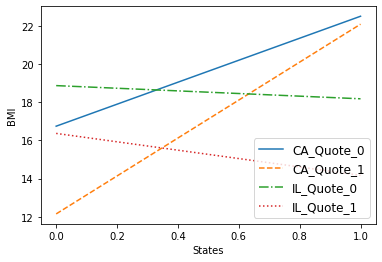

In [29]:
q0 = final_df[final_df.QuoteConversion_Flag == 0].groupby('GeographicField64_CA').mean().BMI
q1 = final_df[final_df.QuoteConversion_Flag == 1].groupby('GeographicField64_CA').mean().BMI

plt.plot(q0.index, q0.values, label = 'CA_Quote_0', linestyle = '-')
plt.plot(q1.index, q1.values, label = 'CA_Quote_1', linestyle = '--')

plt.xlabel('States')
plt.ylabel('BMI')
plt.legend(fontsize = 12)


q2 = final_df[final_df.QuoteConversion_Flag == 0].groupby('GeographicField64_IL').mean().BMI
q3 = final_df[final_df.QuoteConversion_Flag == 1].groupby('GeographicField64_IL').mean().BMI

plt.plot(q2.index, q2.values, label = 'IL_Quote_0', linestyle = 'dashdot')
plt.plot(q3.index, q3.values, label = 'IL_Quote_1', linestyle = ':')

plt.xlabel('States')
plt.ylabel('BMI')
plt.legend(fontsize = 12)

plt.show()

***Observation:*** Customers in CA has BMI ranging from 12 to 25 who has taken the Quote.
>
Customer in IL has maximum BMI range between 16 and 18 who has taken the Quote.

---


**23. Pair plot between Year, Month and Is_Weekend.**

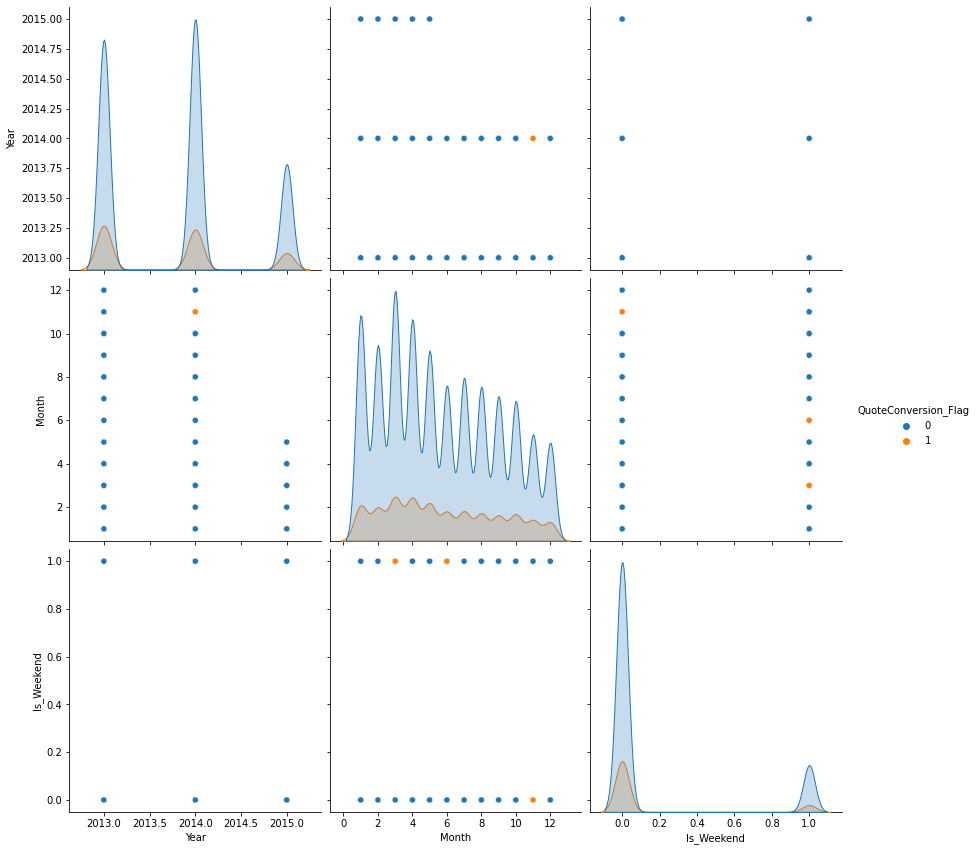

In [30]:
sns.pairplot(final_df, vars = ['Year', 'Month', 'Is_Weekend'], hue = 'QuoteConversion_Flag', height = 4)
plt.show()

***Observation:*** Customers have purchased quote in the month of November 2014 and in March, June.